In [1]:
import wandb
import lightning
import torch 
from model.commentary_models import ActualBoardTransformerMultipleHeadsModel
import sentencepiece
from typing import *
from data.ActualBoardCommentaryDataset import ActualBoardCommentaryDataset
from omegaconf import OmegaConf
import random 
import tqdm
import chess
from PIL import Image
from cairosvg import svg2png
from io import BytesIO


In [2]:
# artifact = wandb.Api().artifact('georgerapeanu/thesis/model-7gx683b3:v49', type='model')
# artifact_dir = artifact.download()

In [3]:
artifact_dir = "artifacts/model-7gx683b3:v49"

In [4]:
model = ActualBoardTransformerMultipleHeadsModel.load_from_checkpoint(artifact_dir + "/model.ckpt")

In [5]:
class ActualBoardPredictor:
    def __init__(
            self,
            context_length: int,
            sp: sentencepiece.SentencePieceProcessor
    ):
        self.__sp = sp
        self.__context_length = context_length

    def tokens_to_string(self, tokens: torch.Tensor) -> str:
        return self.__sp.decode(tokens.view(-1).tolist()).replace("<n>", "\n")

    def predict(self, model, X_board, X_strength, X_reps, X_state, text: str, max_new_tokens: int, target_type: Optional[int] = None) -> str:
        tokens = self.__sp.encode(text.strip().replace('\n', '<n>'))
        tokens = [self.__sp.bos_id()] + tokens
        X_board = X_board.to(model.device)
        X_strength = X_strength.to(model.device)
        X_reps = X_reps.to(model.device)
        X_state = X_state.to(model.device)
        tokens = torch.Tensor(tokens).unsqueeze(0).int().to(model.device)
        tokens = model.generate(X_board.unsqueeze(0), X_strength.unsqueeze(0), X_reps.unsqueeze(0), X_state.unsqueeze(0), tokens, max_new_tokens, target_type=target_type)
        return self.tokens_to_string(tokens)

In [6]:
sp = sentencepiece.SentencePieceProcessor("./artifacts/sp2000.model")
predictor = ActualBoardPredictor(512, sp)

In [7]:
conf = OmegaConf.create({
    "processed_path": "./processed_data",
    "split": "test",
    "count_past_boards": 2,
    "target_types": [0, 1, 2, 3, 4],
    "context_length": 512,
    "stride_big_sequences": 256,
})

engine_conf = OmegaConf.create({
    "mate_value": 10000
})
ds = ActualBoardCommentaryDataset(conf, engine_conf, sp)

In [8]:
choices = random.sample(range(len(ds)), 10)
to_predict = [ds[i] for i in choices]
to_predict_metadata = [ds.get_raw_data(i) for i in choices]


Prediction: 0it [00:00, ?it/s]

predicted: he resigned here, but once he takes a second pawn which I take. Well thanks to his Jimanne, Here book, in which Colle's mate gave me a few moves away now. I cant believe that I'm a pawn down. Sorry? Both players do not see my advantage now...
actual: ??? Strange move???


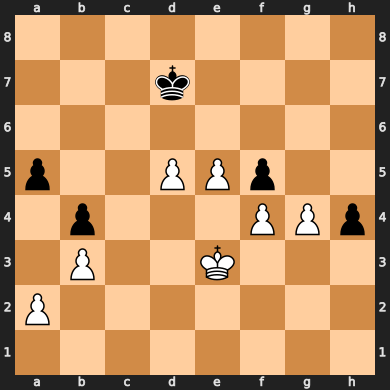

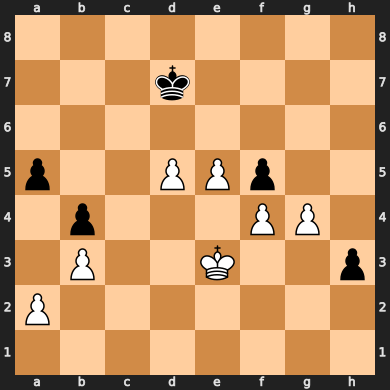

Prediction: 1it [00:01,  1.26s/it]

predicted: Masoning penace on the game
actual: The English opening is very flexible and often transposes into other openings.  It was named for the unofficial English world champion, Howard Staunton, who played it during a match in 1843.


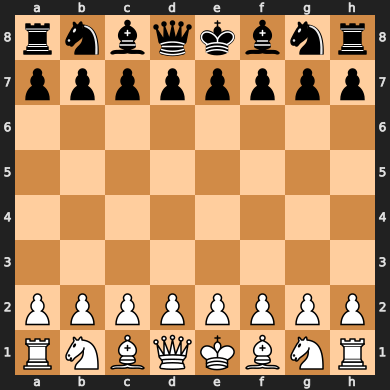

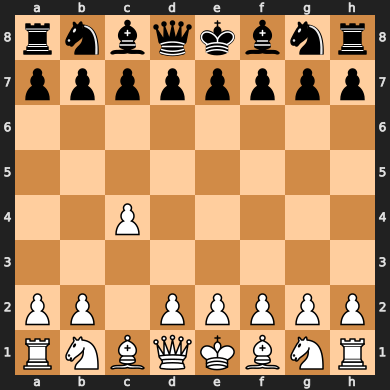

Prediction: 2it [00:01,  1.54it/s]

predicted: with a discovered attack on my f pawn. My opponent is willing to "matchy" as he doesn't have any way to attack on it--not to protect potentially these pawn (which has not really four good moves too, and it can induce far create a threat from 8.h3 ..Rxd4 Rxb8; which is still very poor in his game and with development on their castled King, when I'm sure as really to say what really has happened and make here that Black's position is just a good middle-game. With enough pieces on the bargain of the board before he can exchange queens that's going to complete his development. In addition, it does not have Rb8 undeveloped (since it isn't forgoing anything safer of its denyingy than & castling , not most of it blocks in this in the long term of every pieces, insense of a change and 15.ed while Black doesnt oblige the effect and preference from port for later below those by meaning him failure if he will fall on my correspondence. To this puredehic roomen i'd have such quieficed b

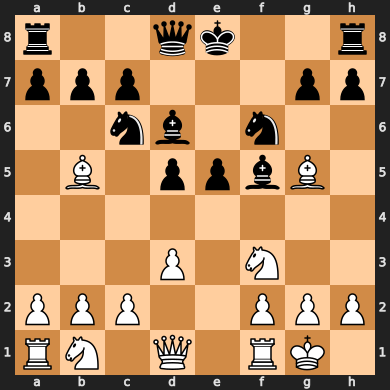

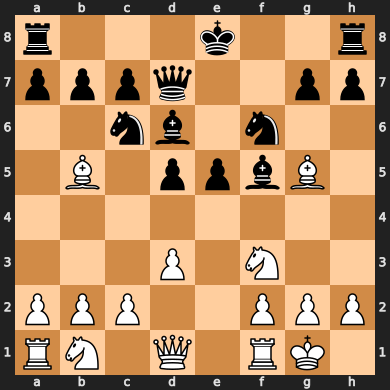

Prediction: 3it [00:08,  3.75s/it]

predicted: We trade pawns off.
actual: 17. d4? looks to be a blunder, though maybe only a minor one. White cannot hold that pawn on d4, as black immediately demonstrates. The threat now is 18. ... Nxc2 forking the two white rooks.


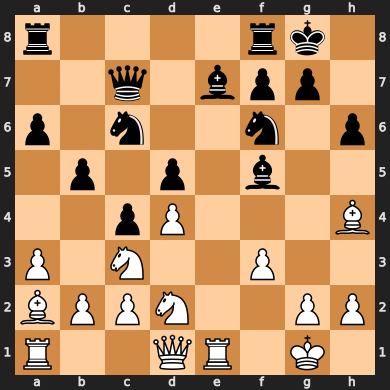

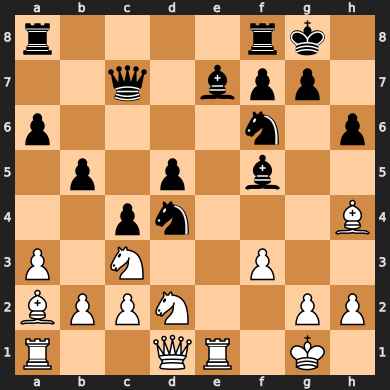

Prediction: 4it [00:09,  2.34s/it]

predicted: Trading my queen for a powerful pawn. No check and see why.
actual: Black chooses mate.


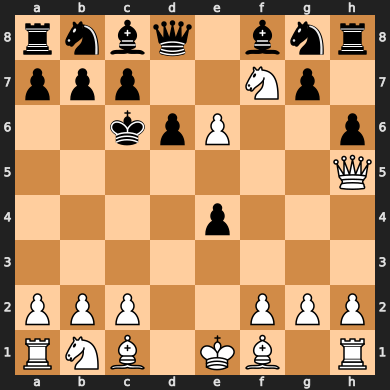

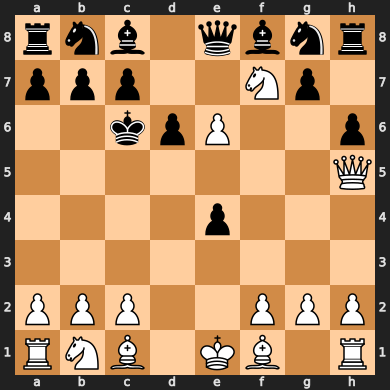

Prediction: 5it [00:09,  1.60s/it]

predicted: White claims the bag by bringing the queen out in the third variations in the opening favor.
actual: I decide it's time to introduce my Queen into the game. A better move was to exchange Knight's.


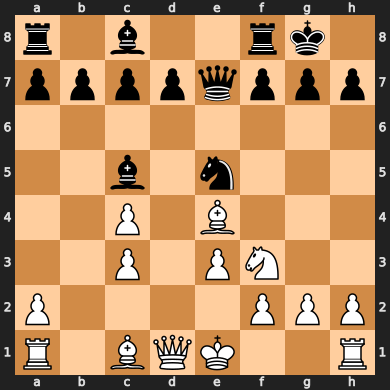

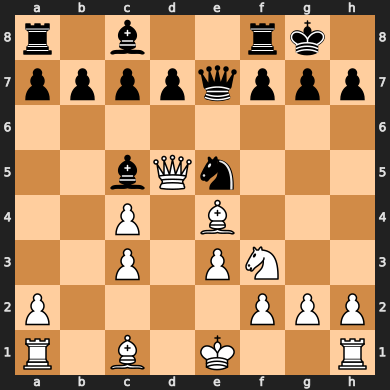

Prediction: 6it [00:09,  1.19s/it]

predicted: I don't think it is a threat to his queen. I should consider d5 and lost the game with Bc8, at least a move.
actual: So now I don't know what to do,  I move too fast.  some stupid comment about my poor OTB play and getting a draw if I can get all of his pieces off the board.  I am damn frustrated.  I resign two other games I was doing poorly in...


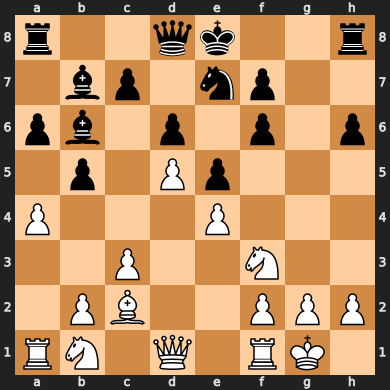

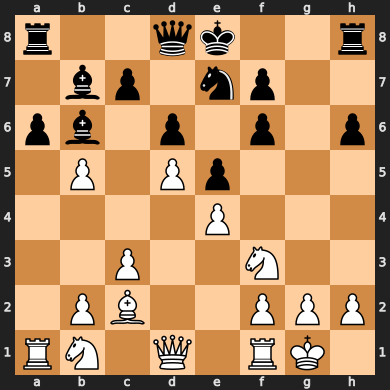

Prediction: 7it [00:10,  1.05it/s]

predicted: ok something like this. This is a real interesting situation, and my defences are not complete.
actual: Threatening Bxb3, where the bishop is immune due to the pin along the c-file.  White would love to play Kb2, but that pesky bishop on g7 prevents it.


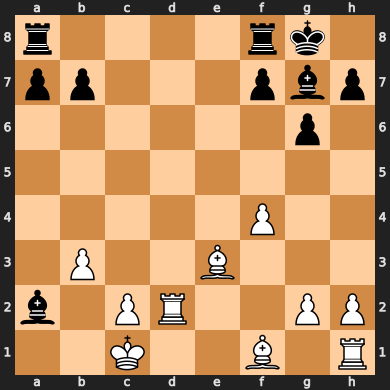

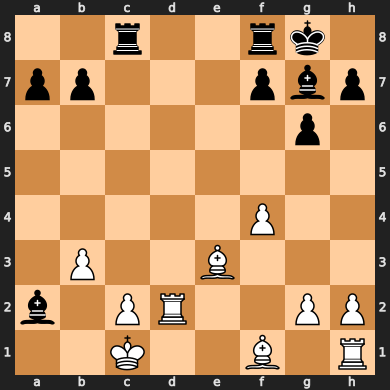

Prediction: 8it [00:10,  1.32it/s]

predicted: "Hope you enjoyed it, I only wanted me to add your fo Old Matey." 1 is a win for black that's king would Queen for a pawn, but he will remet(allst) players will make moves. Thomas, as he eventually gets a passed pawn roller to crashing out there.  He did still remember that game.  What will black did prove!  Any is a shot.  Game to playing quicker round these from back-ups, I missed 20 moves.  I think my as you have a beautiful annotician.  Take!  Anore comments is still on a much stronger side sure.  The game turns is around of any of the much tournament positions contests.  I hope you enjoyed the game, if you should keep your comments, or you started playing without giving white how to erge his opponent will be able to break me up.  I will resign, as you know where i maneuver it was a win it is because of my 6th your opponents, Normal stands for me at me and pen in a safe checks.  I hope you will so just catch the imagbabes throb, I swing the first WQP& PR's LECK, and than

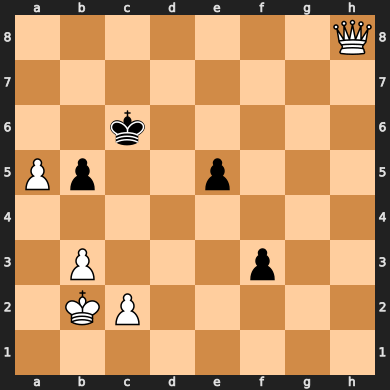

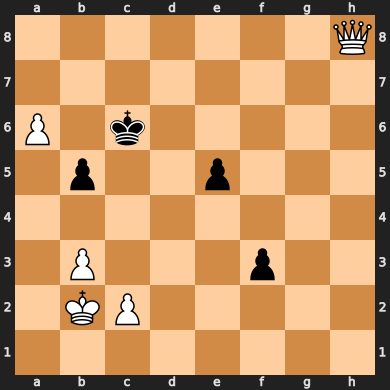

Prediction: 9it [00:17,  2.55s/it]

predicted: Black is going to trade pieces.
actual: The rook at a1 is in danger after 21.Qf3 Rg8+ 22.Kf1 Bh2 (23.Re1 Rg1 mate!), so I plan to move my bishop to g2 to prevent this.


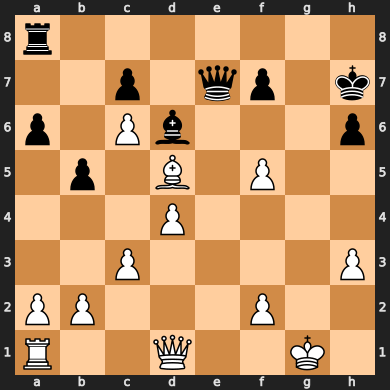

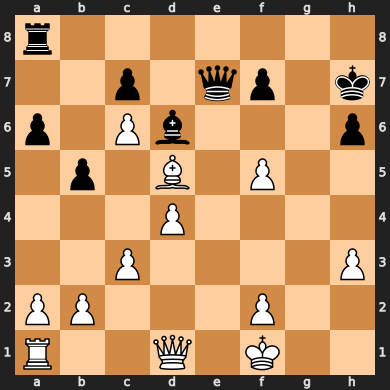

Prediction: 10it [00:17,  1.72s/it]


In [9]:
model.eval()

for ((X_board, X_strength, X_reps, X_state, y_tokens, _), (current_board, past_board, current_eval, past_eval)) in tqdm.tqdm(zip(to_predict, to_predict_metadata), desc="Prediction"):
            predicted_text = predictor.predict(model, X_board, X_strength, X_reps, X_state, '', 1024, target_type=4)
            actual_text = predictor.tokens_to_string(y_tokens)
            past = Image.open(BytesIO(
                    svg2png(chess.svg.board(None if past_board is None else chess.Board(past_board))))).convert(
                    'RGBA')
            curr = Image.open(BytesIO(
                    svg2png(chess.svg.board(None if past_board is None else chess.Board(current_board))))).convert(
                    'RGBA')
            print(f"predicted: {predicted_text}")
            print(f"actual: {actual_text}")
            display(past)
            display(curr)

In [6]:
torch.jit.save(model.to_torchscript(), "./artifacts/model.pt")